In [1]:
import pandas as pd
import gensim
from collections import defaultdict
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn import manifold
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from stylecloud import gen_stylecloud
import numpy as np
from adjustText import adjust_text
from gensim.models import Word2Vec

## 4. 情感主题聚类

### 负向歌词聚类

In [2]:
neg_clean = pd.read_csv("D:/intro/DaSE_intro/final/negative_lyric.csv")
neg_clean.head()

,Unnamed: 0,lyric,clean_lyric
0,0,"Say you're sorry, that face of an angel",face angel
1,1,Comes out just when you need it to,NaN
2,2,As I paced back and forth all this time,paced
3,3,'Cause I honestly believed in you,honestly believed
4,4,"Holdin' on, the days drag on",holdin days drag


In [3]:
stopword = open("D:/intro/DaSE_intro/final/stopwords.txt", 'r').read()
sentence = [] # 分割好的清理后歌词

for s in neg_clean['clean_lyric']:
    if s is None:
        continue
    sentence.append(str(s))
for i in range(len(sentence)):
    sentence[i] = sentence[i].split()

# 跑完第一次stop words去的不干净
sentences = [[word for word in line if word not in stopword]for line in sentence]

from gensim.models import Word2Vec

model = gensim.models.Word2Vec(sentences, min_count = 25, window = 5)
words = list(model.wv.key_to_index) # 所有单词

In [4]:
# 分词
corpus = []
# t = []
temp = []
for text in neg_clean['clean_lyric']:
    if text is np.nan:
        continue
    corpus.append(text)

In [5]:
# 计算TF-TDF
vectorizer = CountVectorizer()
word_vec = vectorizer.fit_transform(corpus)
    
#提取TF-IDF词向量
transformer = TfidfTransformer()
tfidf = transformer.fit_transform(word_vec)
tfidf_matrix = tfidf.toarray() #对应tfidf矩阵

tfidf_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [6]:
# 获得词频
sentence = [] # 分割好的清理后歌词
for s in neg_clean['clean_lyric']:
    sentence.append(str(s))
for i in range(len(sentence)):
    sentence[i] = sentence[i].split()

# 跑完第一次stop words去的不干净
sentences = [[word for word in line if word not in stopword]for line in sentence]

model = gensim.models.Word2Vec(sentences, min_count = 25, window = 5)
words = list(model.wv.key_to_index) # 所有单词

frequency = defaultdict(int)
for line in sentences:
    for token in line:
        frequency[token] += 1
words_frequency = [frequency[word] for word in words]
word_frequency = pd.DataFrame({"单词":words,"频率":words_frequency})
word_frequency.head(10)

,单词,频率
0,shake,79
1,baby,75
2,bad,47
3,love,40
4,forever,33
5,night,33
6,trouble,32
7,girl,32
8,waiting,28
9,thought,27


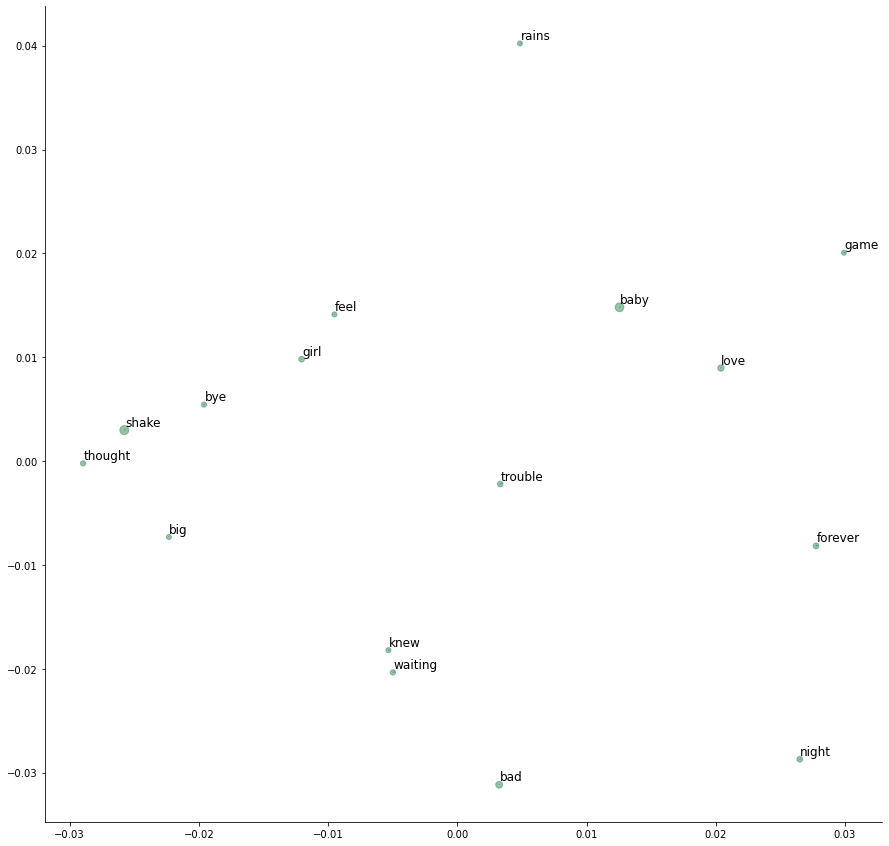

In [7]:
#先看PCA的可视化效果
X = model.wv[words]
pca = PCA(n_components=2)
result = pca.fit_transform(X)

ig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(result[:, 0], result[:, 1], c='SeaGreen', s=words_frequency,alpha=0.5) # 绘制散点图，圆圈就是出现的频率

# 不同的圆圈有时会重叠在一起，可以使用adjustText修正文字重叠现象

from adjustText import adjust_text
new_texts = [plt.text(x, y, text, fontsize=12) for x, y, text in zip(result[:, 0], result[:, 1], words)]

adjust_text(new_texts, 
            only_move={'text': 'x'},
            arrowprops=dict(arrowstyle='-', color='grey'))

# 美观起见隐藏顶部与右侧边框线
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

D:\Anaconda\envs\intro\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\Anaconda\envs\intro\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


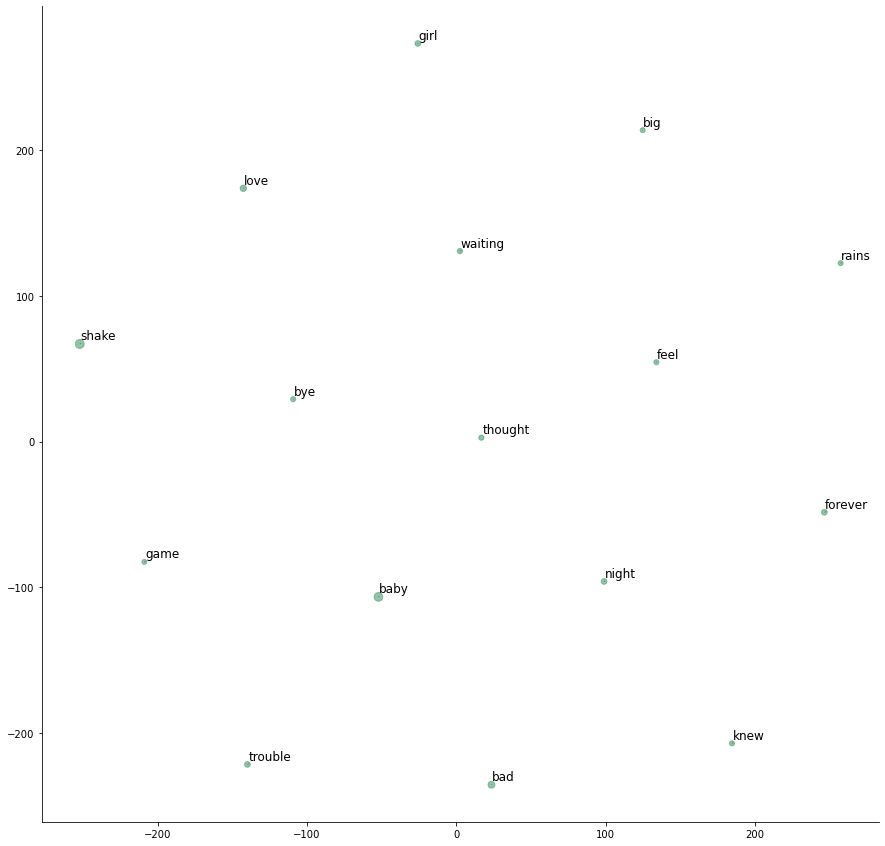

In [8]:
# TSNE降维
ts =TSNE(2)
result2 = ts.fit_transform(X)

fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(result2[:, 0], result2[:, 1], c = 'SeaGreen', s = words_frequency, alpha = 0.5) # 绘制散点图

# 使用adjustText修正文字重叠现象
new_texts = [plt.text(x, y, text, fontsize=12) for x, y, text in zip(result2[:, 0], result2[:, 1], words)]
adjust_text(new_texts, 
            only_move={'text': 'x'},
            arrowprops=dict(arrowstyle='-', color='grey'))

# 美观起见隐藏顶部与右侧边框线
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

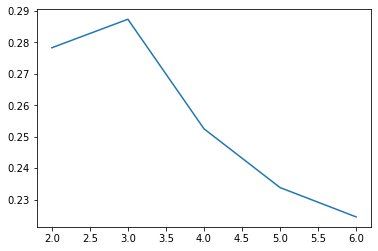

In [9]:
# 聚类
#先用轮廓系数绘制学习曲线找出最优类别数
ss = []
krange = list(range(2,7)) #看一下在2-6之间的得到
for k in range(2,7):
    model = KMeans(n_clusters= k,random_state=0)       # 实例化
    model = model.fit(result2)
    ss.append(silhouette_score(result2, model.labels_))
plt.plot(krange,ss)
plt.savefig("./cluster.png", dpi = 1000)

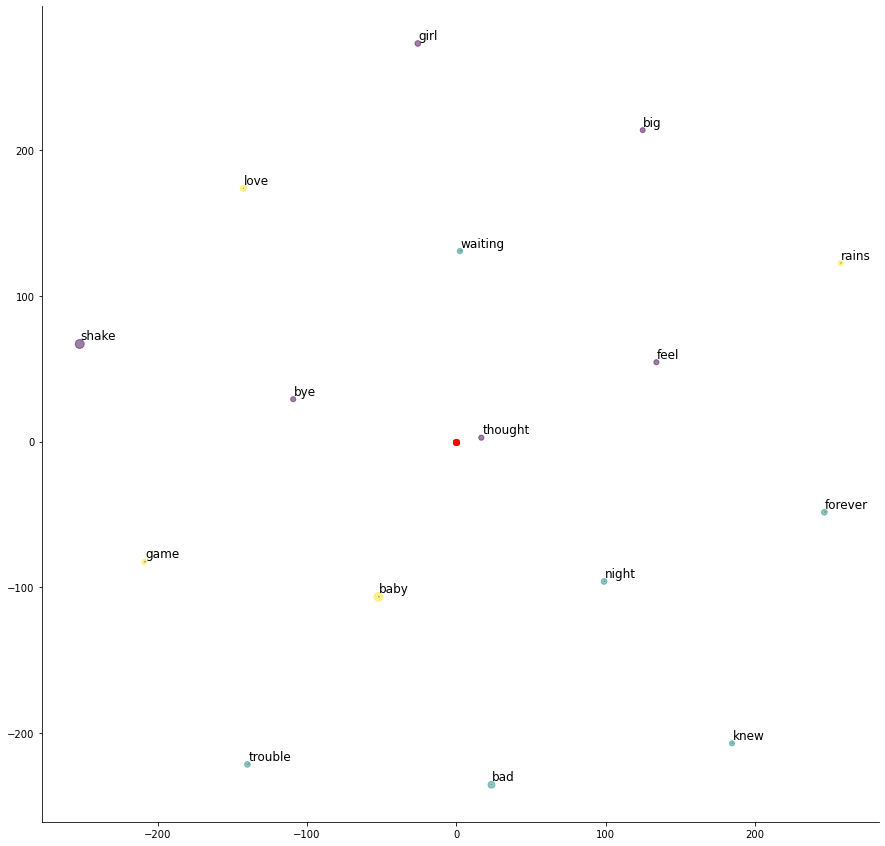

In [10]:
#用PCA降维数据后的分类结果
fig, ax = plt.subplots(figsize=(15, 15))
model = KMeans(n_clusters= 3, random_state=0,init="k-means++")
model = model.fit(result)              
# 将聚类的结果和中心点的结果都画在原图里面
plt.scatter(result2[:, 0], result2[:, 1], c = model.labels_,s= words_frequency,alpha=0.5)
plt.scatter(model.cluster_centers_[: , 0],model.cluster_centers_[:, 1], color = "red") #加上每一个的中心带你

new_texts = [plt.text(x, y, text, fontsize=12) for x, y, text in zip(result2[:, 0], result2[:, 1], words)]
adjust_text(new_texts, 
            only_move={'text': 'x'},
            arrowprops=dict(arrowstyle='-', color='grey'))

# 美观起见隐藏顶部与右侧边框线
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

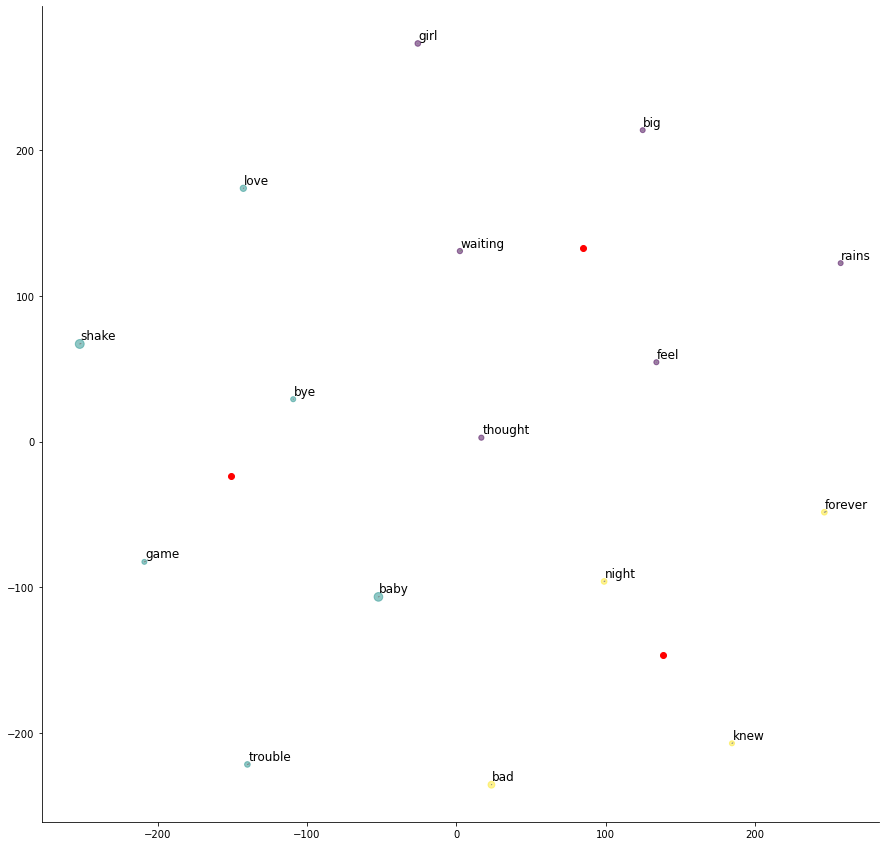

In [11]:
#进行聚类
fig, ax = plt.subplots(figsize=(15, 15))

model = KMeans(n_clusters= 3,random_state=0,init="k-means++")# 实例化
model = model.fit(result2)
               
# 将聚类的结果和中心点的结果都画在原图里面
plt.scatter(result2[:, 0], result2[:, 1], c = model.labels_,s= words_frequency,alpha=0.5)
plt.scatter(model.cluster_centers_[: , 0],model.cluster_centers_[:, 1], color = "red")

new_texts = [plt.text(x, y, text, fontsize=12) for x, y, text in zip(result2[:, 0], result2[:, 1], words)]
adjust_text(new_texts, 
            only_move={'text': 'x'},
            arrowprops=dict(arrowstyle='-', color='grey'))

# 美观起见隐藏顶部与右侧边框线
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

### 正向歌词聚类

In [12]:
pos_clean = pd.read_csv("D:/intro/DaSE_intro/final/positive_lyric.csv")
pos_clean.head()

,Unnamed: 0,lyric,clean_lyric
0,0,There's something 'bout the way,NaN
1,1,The street looks when it's just rained,street rained
2,2,"There's a glow off the pavement, you walk me t...",glow pavement walk car
3,3,And you know I wanna ask you to dance right there,NaN
4,4,"In the middle of the parking lot, yeah",middle parking lot


In [13]:
sentence = [] # 分割好的清理后歌词

for s in pos_clean['clean_lyric']:
    if s is None:
        continue
    sentence.append(str(s))
for i in range(len(sentence)):
    sentence[i] = sentence[i].split()

# 跑完第一次stop words去的不干净
sentences = [[word for word in line if word not in stopword]for line in sentence]

model = gensim.models.Word2Vec(sentences, min_count = 25, window = 5)
words = list(model.wv.key_to_index) # 所有单词

In [14]:
# 分词
corpus = []
# t = []
temp = []
for text in pos_clean['clean_lyric']:
    if text is np.nan:
        continue
    corpus.append(text)

In [15]:
# 计算TF-TDF
vectorizer = CountVectorizer()
word_vec = vectorizer.fit_transform(corpus)
    
#提取TF-IDF词向量
transformer = TfidfTransformer()
tfidf = transformer.fit_transform(word_vec)
tfidf_matrix = tfidf.toarray() #对应tfidf矩阵

tfidf_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [16]:
# 获得词频
sentence = [] # 分割好的清理后歌词
for s in pos_clean['clean_lyric']:
    sentence.append(str(s))
for i in range(len(sentence)):
    sentence[i] = sentence[i].split()

# 跑完第一次stop words去的不干净
sentences = [[word for word in line if word not in stopword]for line in sentence]

model = gensim.models.Word2Vec(sentences, min_count = 25, window = 5)
words = list(model.wv.key_to_index) # 所有单词

frequency = defaultdict(int)
for line in sentences:
    for token in line:
        frequency[token] += 1
words_frequency = [frequency[word] for word in words]
word_frequency = pd.DataFrame({"单词":words,"频率":words_frequency})
word_frequency.head(10)

,单词,频率
0,love,269
1,baby,111
2,stay,107
3,night,89
4,good,85
5,feel,76
6,things,65
7,eyes,62
8,knew,58
9,girl,58


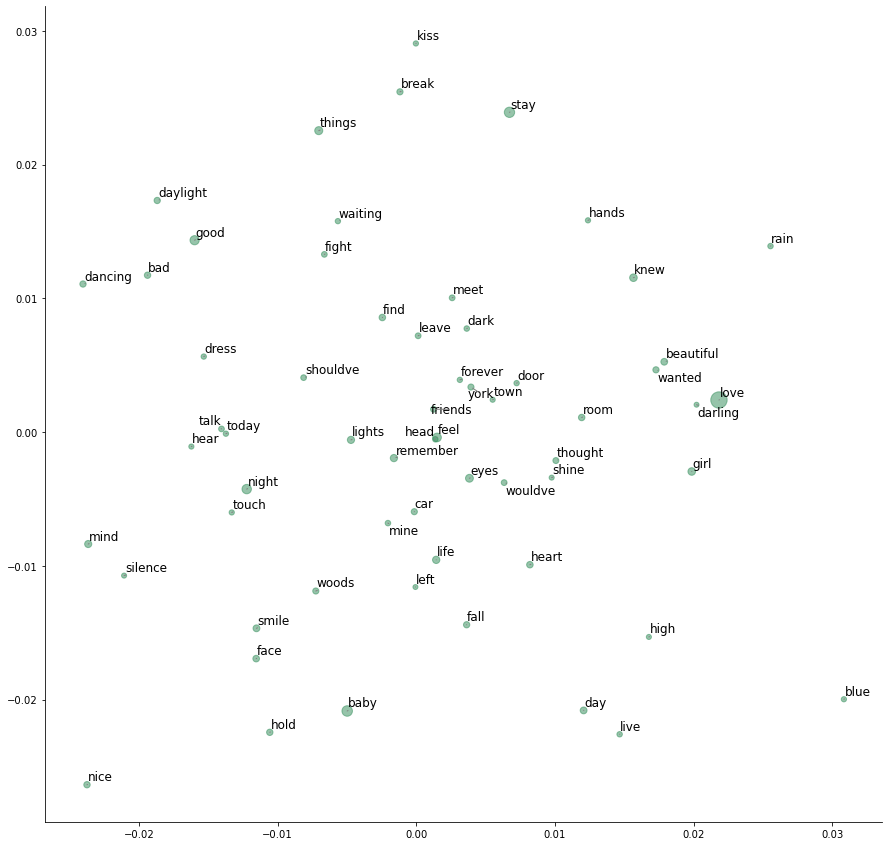

In [17]:
#先看PCA的可视化效果
X = model.wv[words]
pca = PCA(n_components=2)
result = pca.fit_transform(X)

ig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(result[:, 0], result[:, 1], c='SeaGreen', s=words_frequency,alpha=0.5) # 绘制散点图，圆圈就是出现的频率

# 不同的圆圈有时会重叠在一起，可以使用adjustText修正文字重叠现象

new_texts = [plt.text(x, y, text, fontsize=12) for x, y, text in zip(result[:, 0], result[:, 1], words)]

adjust_text(new_texts, 
            only_move={'text': 'x'},
            arrowprops=dict(arrowstyle='-', color='grey'))

# 美观起见隐藏顶部与右侧边框线
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig("./pca.png", dpi = 1000)

D:\Anaconda\envs\intro\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\Anaconda\envs\intro\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


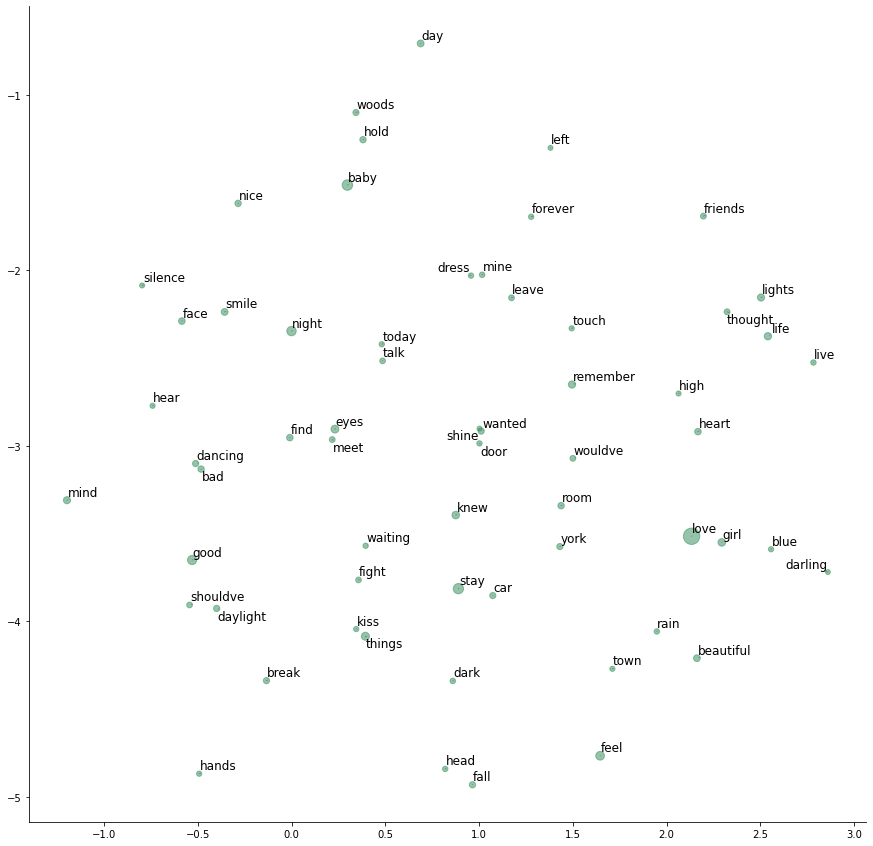

In [18]:
# TSNE降维
ts =TSNE(2)
result2 = ts.fit_transform(X)

fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(result2[:, 0], result2[:, 1], c = 'SeaGreen', s = words_frequency, alpha = 0.5) # 绘制散点图

# 使用adjustText修正文字重叠现象
new_texts = [plt.text(x, y, text, fontsize=12) for x, y, text in zip(result2[:, 0], result2[:, 1], words)]
adjust_text(new_texts, 
            only_move={'text': 'x'},
            arrowprops=dict(arrowstyle='-', color='grey'))

# 美观起见隐藏顶部与右侧边框线
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig("./tsne.png", dpi = 1000)

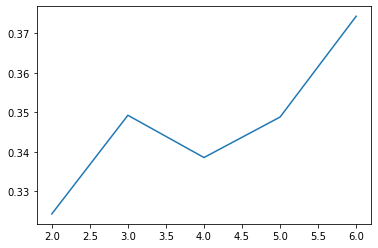

In [19]:
# 聚类
#先用轮廓系数绘制学习曲线找出最优类别数
ss = []
krange = list(range(2,7)) #看一下在2-6之间的得到
for k in range(2,7):
    model = KMeans(n_clusters= k,random_state=0)       # 实例化
    model = model.fit(result2)
    ss.append(silhouette_score(result2, model.labels_))
plt.plot(krange,ss)

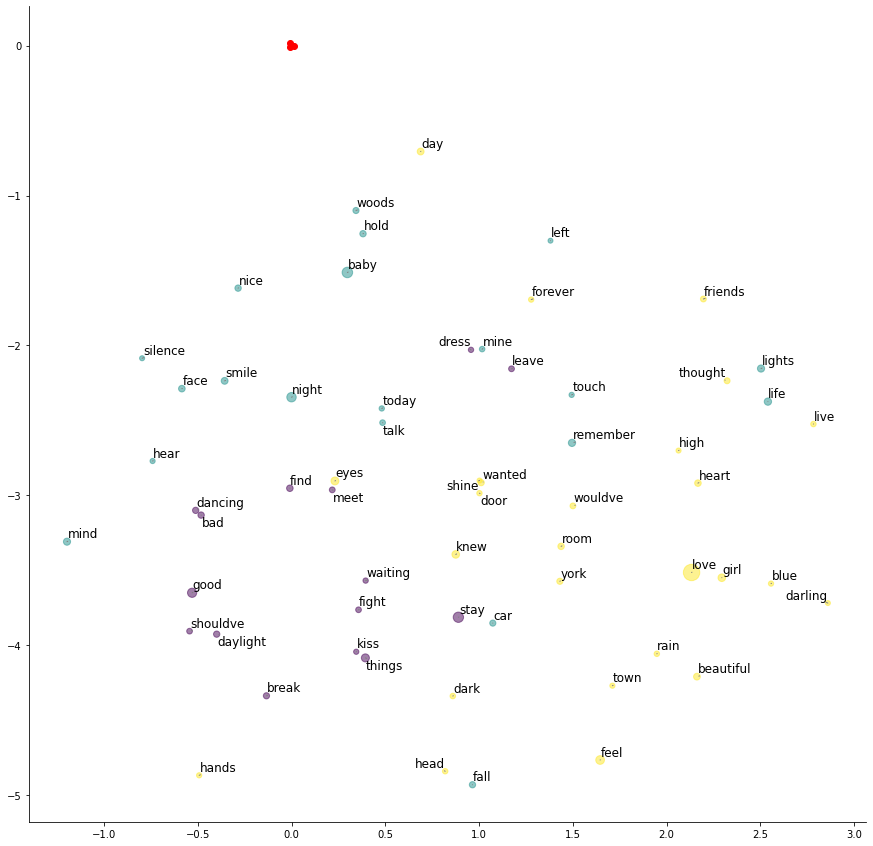

In [20]:
#用PCA降维数据后的分类结果
fig, ax = plt.subplots(figsize=(15, 15))
model = KMeans(n_clusters= 3, random_state=0,init="k-means++")
model = model.fit(result)              
# 将聚类的结果和中心点的结果都画在原图里面
plt.scatter(result2[:, 0], result2[:, 1], c = model.labels_,s= words_frequency,alpha=0.5)
plt.scatter(model.cluster_centers_[: , 0],model.cluster_centers_[:, 1], color = "red") #加上每一个的中心带你

new_texts = [plt.text(x, y, text, fontsize=12) for x, y, text in zip(result2[:, 0], result2[:, 1], words)]
adjust_text(new_texts, 
            only_move={'text': 'x'},
            arrowprops=dict(arrowstyle='-', color='grey'))

# 美观起见隐藏顶部与右侧边框线
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig("./pca_cluster.png", dpi = 1000)

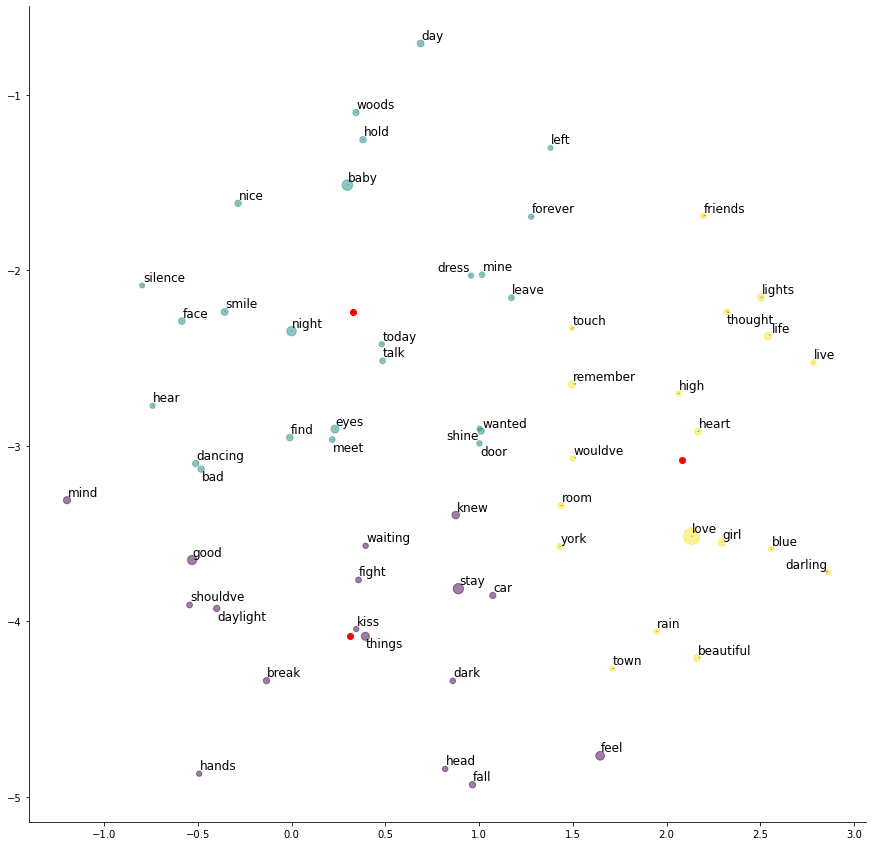

In [21]:
#进行聚类
fig, ax = plt.subplots(figsize=(15, 15))

model = KMeans(n_clusters= 3,random_state=0,init="k-means++")# 实例化
model = model.fit(result2)
               
# 将聚类的结果和中心点的结果都画在原图里面
plt.scatter(result2[:, 0], result2[:, 1], c = model.labels_,s= words_frequency,alpha=0.5)
plt.scatter(model.cluster_centers_[: , 0],model.cluster_centers_[:, 1], color = "red")

new_texts = [plt.text(x, y, text, fontsize=12) for x, y, text in zip(result2[:, 0], result2[:, 1], words)]
adjust_text(new_texts, 
            only_move={'text': 'x'},
            arrowprops=dict(arrowstyle='-', color='grey'))

# 美观起见隐藏顶部与右侧边框线
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig("./tsne_cluster.png", dpi = 1000)